In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import pickle

In [2]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow_data/mlflow.db")
mlflow.set_experiment("taxi_trip_duration_pred_1")

2023/02/01 18:54:29 INFO mlflow.tracking.fluent: Experiment with name 'taxi_trip_duration_pred_1' does not exist. Creating a new experiment.


<Experiment: artifact_location='./mlruns/1', creation_time=1675270469090, experiment_id='1', last_update_time=1675270469090, lifecycle_stage='active', name='taxi_trip_duration_pred_1', tags={}>

In [3]:
df = pd.read_parquet("./data/green_tripdata_2021-01.parquet")
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00


In [4]:
# calculate total duration of trip in miuntes
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
df = df[(df.duration >= 1) & (df.duration <= 60)]

<AxesSubplot: xlabel='duration', ylabel='Count'>

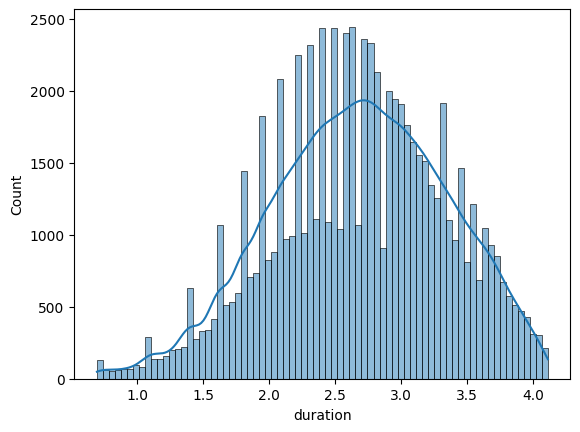

In [5]:
# plot log distribution of duration...
sns.histplot(np.log1p(df.duration), label='actual', kde = True)

In [6]:
# transform target variable to log scale
df.duration = np.log1p(df.duration)

In [7]:
# extract some features like weekday, hour and day..
df["pickup_hour"] = df["lpep_pickup_datetime"].dt.hour
df["pickup_day"] = df["lpep_pickup_datetime"].dt.day
df["pickup_weekday"] = df["lpep_pickup_datetime"].dt.weekday

In [8]:
# decide categorical and numerical variables...
categorical = ["PULocationID", "DOLocationID", "pickup_weekday"]
numerical = ["trip_distance", "pickup_day", "pickup_hour"]
df[categorical] = df[categorical].astype(str)

In [9]:
# turn pandas dataframe to dictionay vectorizer
train_dicts = df[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
target = 'duration'
y_train = df[target].values

In [10]:
# predict using linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_train)
mean_squared_error(y_train, y_pred, squared=False)

0.5538898347464111

C:\Users\hp\AppData\Local\Temp\ipykernel_1532\972592612.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.expm1(y_pred), label='prediction')
C:\Users\hp\AppData\Local\Temp\ipykernel_1532\972592612.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.expm1(y_train), label='actual')


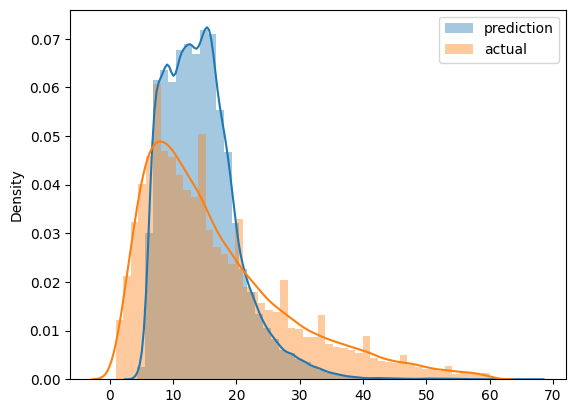

In [11]:
sns.distplot(np.expm1(y_pred), label='prediction')
sns.distplot(np.expm1(y_train), label='actual')
plt.legend()

In [12]:
mean_squared_error(np.expm1(y_train), np.expm1(y_pred), squared=False)

10.27879610663968

In [13]:
# function to do all the prev steps.
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)
        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    df.duration = np.log1p(df.duration)
    df["pickup_hour"] = df["lpep_pickup_datetime"].dt.hour
    df["pickup_day"] = df["lpep_pickup_datetime"].dt.day
    df["pickup_weekday"] = df["lpep_pickup_datetime"].dt.weekday
    categorical = ['PULocationID', 'DOLocationID','pickup_weekday']
    df[categorical] = df[categorical].astype(str)
    return df

In [14]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [15]:
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [16]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
mean_squared_error(np.expm1(y_val), np.expm1(y_pred), squared=False)

11.141115686617912

In [18]:
rlr = Ridge()
rlr.fit(X_train, y_train)
y_pred_r = rlr.predict(X_val)
mean_squared_error(np.expm1(y_val), np.expm1(y_pred_r), squared=False)

11.105762729177659

In [19]:
with open("./models/linear_reg.bin", "wb") as model:
    pickle.dump((dv, lr), model)

In [21]:
with mlflow.start_run():
    mlflow.set_tag("dev", "Madi")
    mlflow.set_tag("Model", "Lasso Regularized Model")
    mlflow.log_param("train_data", "./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid_data", "./data/green_tripdata_2021-02.parquet")
    alpha = 0.01
    mlflow.log_param("alpha", alpha)
    lr = Lasso()
    lr.fit(X_train, y_train)
    y_pred_l = lr.predict(X_val)
    mse = mean_squared_error(np.expm1(y_val), np.expm1(y_pred_l), squared=False)
    mlflow.log_metric("MSE", mse)

In [23]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [24]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [29]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("dev", "Ezzaldin")
        mlflow.set_tag("Model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        mse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("MSE", mse)
    return {'loss': mse, 'status': STATUS_OK}

In [30]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

In [31]:
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[19:27:10] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:2.06373                           
[1]	validation-rmse:1.83315                           
[2]	validation-rmse:1.63034                           
[3]	validation-rmse:1.45216                           
[4]	validation-rmse:1.29559                           
[5]	validation-rmse:1.15816                           
[6]	validation-rmse:1.03780                           
[7]	validation-rmse:0.93293                           
[8]	validation-rmse:0.84112                           
[9]	validation-rmse:0.76128                           
[10]	validation-rmse:0.69190                          
[11]	validation-rmse:0.63172                          
[12]	validation-rmse:0.57994                          
[13]	validation-rmse:0.53545                          

KeyboardInterrupt: 

In [33]:
# xgb hyperparameters
params = {
    "learning_rate":	0.18258512600445959,
    "max_depth":	7,
    "min_child_weight":	1.143585571683418,
    "objective":	"reg:linear",
    "reg_alpha":	0.013583822711132985,
    "reg_lambda":	0.07048674371862883,
    "seed":	42
}

In [34]:
train = xgb.DMatrix(X_train, label=np.expm1(y_train))
valid = xgb.DMatrix(X_val, label=np.expm1(y_val))

In [35]:
mlflow.xgboost.autolog()

booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )

2023/02/01 20:39:24 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.
2023/02/01 20:39:24 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '24745b244c004606bc85c547279754c4', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[20:39:24] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17.94813
[1]	validation-rmse:15.35324
[2]	validation-rmse:13.29193
[3]	validation-rmse:11.67023
[4]	validation-rmse:10.40532
[5]	validation-rmse:9.42532
[6]	validation-rmse:8.67360
[7]	validation-rmse:8.10488
[8]	validation-rmse:7.67547
[9]	validation-rmse:7.34123
[10]	validation-rmse:7.09312
[11]	validation-rmse:6.90674
[12]	validation-rmse:6.76024
[13]	validation-rmse:6.63861
[14]	validation-rmse:6.55048
[15]	validation-rmse:6.47882
[16]	validation-rmse:6.41477
[17]	validation-rmse:6.37235
[18]	validation-rmse:6.33011
[19]	validation-rmse:6.30600
[20]	validation-rmse:6.28059
[21]	validation-rmse:6.25877
[22]	validation-rmse:6.22896
[23]	validation-rmse:6.21376
[24]	validation-rmse:6.19167
[25]	validation-rmse:6.16858
[26]	validation-rmse

2023/02/01 20:40:57 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2023/02/01 20:41:27 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\hp\anaconda3\envs\prefect_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils."
